# Exploring the UTx000 Dataset
From the first cohort in Spring 2020

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Accelerometer Processing
The largest dataset by far that contains the highest resolution of data. This data can be used a proxy for Beiwe/phone operation.

In [3]:
import os

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

# Test Data Import
We want to import some data from participants so that we can understand it a little bit more.

## One datafile

In [4]:
raw = pd.read_csv('/Volumes/HEF_Dissertation_Research/utx000/bpeace1/beiwe/accelerometer/25rlmdr1/accelerometer/2020-01-24 23_00_00.csv')
raw

,timestamp,UTC time,accuracy,x,y,z
0,1579907340562,2020-01-24T23:09:00.562,3,-0.187937,6.176775,8.001079
1,1579907340565,2020-01-24T23:09:00.565,3,-0.395026,6.160016,8.356602
2,1579907340565,2020-01-24T23:09:00.565,3,-0.593737,6.114528,8.244080
3,1579907340565,2020-01-24T23:09:00.565,3,-0.828358,6.380273,8.422440
4,1579907340565,2020-01-24T23:09:00.565,3,-0.949260,6.569407,8.628332
...,...,...,...,...,...,...
3083,1579907400271,2020-01-24T23:10:00.271,3,-0.219060,4.420703,7.861023
3084,1579907400272,2020-01-24T23:10:00.272,3,-0.052670,4.403945,7.515076
3085,1579907400283,2020-01-24T23:10:00.283,3,-0.243001,4.493724,7.523456
3086,1579907400324,2020-01-24T23:10:00.324,3,-0.501564,4.664902,7.633584


Looking at just one data file which spans only one hour, we have over 3000 entries. The timestamps don't seem consistent either but are much less than 1-minute which is probaly the finest resolution that we need in the processed data.

## One participant

In [5]:
pt_dir = '/Volumes/HEF_Dissertation_Research/utx000/bpeace1/beiwe/accelerometer/25rlmdr1/accelerometer/'
pt_df = pd.DataFrame()
for file in os.listdir(pt_dir):
    temp = pd.read_csv(f'{pt_dir}{file}',parse_dates = [1],infer_datetime_format=True,index_col=1)
    pt_df = pt_df.append(temp)
    
pt_df.head()

,timestamp,accuracy,x,y,z
UTC time,,,,,
2020-01-24 23:09:00.562,1579907340562,3,-0.187937,6.176775,8.001079
2020-01-24 23:09:00.565,1579907340565,3,-0.395026,6.160016,8.356602
2020-01-24 23:09:00.565,1579907340565,3,-0.593737,6.114528,8.244080
2020-01-24 23:09:00.565,1579907340565,3,-0.828358,6.380273,8.422440
2020-01-24 23:09:00.565,1579907340565,3,-0.949260,6.569407,8.628332


### Visualizing to see gaps

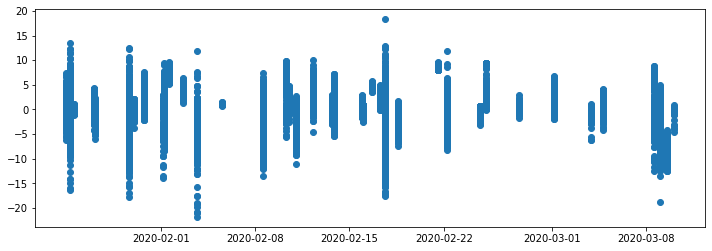

In [6]:
pt_df['time'] = pd.to_datetime(pt_df.index) - timedelta(hours=6)
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(pt_df.index,pt_df['x'])
plt.show()
plt.close()

Data seem rather sparse actually. I was expecting something a little more continuous. Regardless, we can upsample to at least seconds to see what we get:

### Upsampling analysis

Number of raw datapoints:		104861
Number of upsampled 500ms datapoints:	4845 - 4.620402246783837% of original data


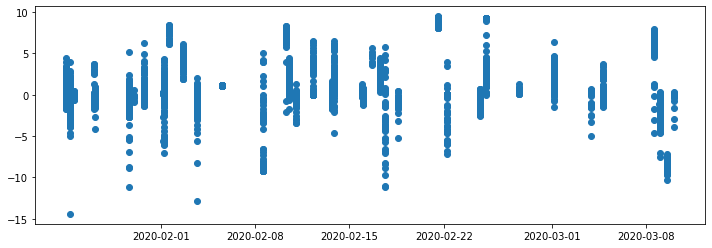

Number of upsampled 1000ms datapoints:	2459 - 2.3450091072944184% of original data


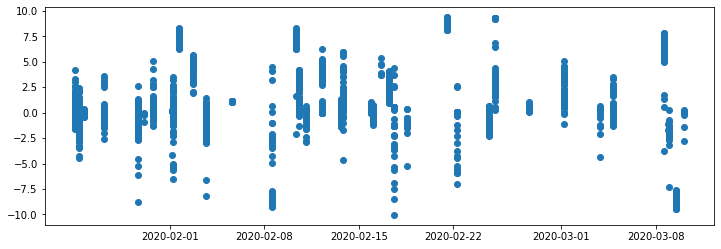

In [7]:
n_raw = len(pt_df)
print(f'Number of raw datapoints:\t\t{n_raw}')
for seconds in [500,1000]:
    pt_df_s = pt_df.resample(f'{seconds}ms').mean()
    pt_df_s.dropna(inplace=True)
    n_s = len(pt_df_s)
    print(f'Number of upsampled {seconds}ms datapoints:\t{n_s} - {n_s/n_raw*100}% of original data')
    fig, ax = plt.subplots(figsize=(12,4))
    ax.scatter(pt_df_s.index,pt_df_s['x'])
    plt.show()
    plt.close()

Seems like 500 ms is a good enough resampling rate

# Processing Pipeline

In [10]:
pt_dir = '/Volumes/HEF_Dissertation_Research/utx000/bpeace1/beiwe/accelerometer/'
resample_rate = 100 #ms
accel_df = pd.DataFrame()
for pt in os.listdir(pt_dir)[:3]:
    if len(pt) == 8:
        pt_df = pd.DataFrame()
        for file in os.listdir(f'{pt_dir}{pt}/accelerometer/'):
            file_df = pd.read_csv(f'{pt_dir}{pt}/accelerometer/{file}',parse_dates = [1],infer_datetime_format=True)
            pt_df = pt_df.append(file_df)
        
        pt_df.set_index(['UTC time'],inplace=True)
        pt_df.sort_index(inplace=True)
        pt_df = pt_df.resample(f'{resample_rate}ms').mean()
        pt_df.dropna(inplace=True)
        pt_df['beiwe'] = pt
        
        accel_df = accel_df.append(pt_df)
    
accel_df['CST time'] = accel_df.index - timedelta(hours=6)
accel_df.head()

,timestamp,accuracy,x,y,z,beiwe,CST time
UTC time,,,,,,,
2020-01-24 23:09:00.500,1.579907e+12,3.0,-0.589397,6.408553,8.307074,25rlmdr1,2020-01-24 17:09:00.500
2020-01-24 23:09:00.600,1.579907e+12,3.0,0.317697,6.457363,8.652752,25rlmdr1,2020-01-24 17:09:00.600
2020-01-24 23:09:00.700,1.579907e+12,3.0,2.435653,5.860412,6.722800,25rlmdr1,2020-01-24 17:09:00.700
2020-01-24 23:09:00.900,1.579907e+12,3.0,4.351601,5.880342,5.957606,25rlmdr1,2020-01-24 17:09:00.900
2020-01-24 23:09:01.100,1.579907e+12,3.0,3.631967,6.610585,6.287502,25rlmdr1,2020-01-24 17:09:01.100
